# Tabular models

In [0]:
 !curl https://course-v3.fast.ai/setup/colab | bash

In [0]:
!pip install dataclasses

In [0]:
from fastai import *
from fastai.tabular import *

Tabular data should be in a Pandas `DataFrame`.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
def read_merge():
    path = 'content/gdrive/My Drive/'
    with open('/content/gdrive/My Drive/events.csv', 'r') as f:
      df_events = pd.read_csv(f)
    with open('/content/gdrive/My Drive/ginf.csv', 'r') as f:
      df_game_info = pd.read_csv(f)
    
    # manually convert the dictionary.txt to python dicts
    event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
    event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
    sides = {1:'Home', 2:'Away'}
    shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
    shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
    locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
    bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
    assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
    situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}
    
    # Mapping the dicts into the events dataframe
    df_events['event_type'] =   df_events['event_type'].map(event_types)
    df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
    df_events['side'] =         df_events['side'].map(sides)
    df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
    df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
    df_events['location'] =     df_events['location'].map(locations)
    df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
    df_events['assist_method']= df_events['assist_method'].map(assist_methods)
    df_events['situation'] =    df_events['situation'].map(situations)

    ## Naming the leagues with their popular names, which will make thinks much clear for us
    leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
              'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

    ## Map them to events
    df_game_info.league = df_game_info.league.map(leagues)

    # Merge into one table (merge other dataset to have country, league, date and season)
    df_events = df_events.merge(df_game_info ,how = 'left')
    
    return df_events
  
def fill_unk(df):
    '''
    Fill the following categorical features in df with 'UNK':
    shot_place, player, shot_outcome, bodypart, location and assist_method
    '''
    # Fill the required features with new class 'unknown'
    df.shot_place.fillna('UNK'   ,inplace = True)
    df.player.fillna('UNK'       ,inplace = True)
    df.shot_outcome.fillna('UNK' ,inplace = True)
    df.bodypart.fillna('UNK'     ,inplace = True)
    df.location.fillna('UNK'     ,inplace = True)
    df.assist_method.fillna('UNK',inplace = True)
    df.situation.fillna('UNK'    ,inplace = True)
    df.location.replace('Not recorded', 'UNK', inplace= True)
    
def fix_dtypes(df, cats):
  '''
  fixes the category datatypes for cats features
  '''
  # Notice that a lot of the floats and ints are in fact categoricals
  # We can fix this with Pandas' astype function
  d = dict.fromkeys(cats,'category')
  df = df.astype(d)
  df['is_goal'] = df['is_goal'].astype('bool') # this is a bool
  df['fast_break'] = df['fast_break'].astype('bool')

  df.odd_a = df.odd_a.astype('float16')
  df.odd_d = df.odd_d.astype('float16')
  df.odd_h = df.odd_h.astype('float16')
  df.odd_over  = df.odd_over.astype('float16')
  df.odd_under = df.odd_under.astype('float16')               
  df.odd_bts   = df.odd_bts.astype('float16')
  df.odd_bts_n = df.odd_bts_n.astype('float16')

  df.ftag = df.ftag.astype('int8')
  df.fthg = df.fthg.astype('int8')
  df.time = df.time.astype('int8')

  df.season =     df.season.astype('category')
  df.league =     df.league.astype('category')
  df.country =    df.country.astype('category')
  df.date = pd.to_datetime(df.date)
  return df

def missing_values_table(df):
  '''
  Function to calculate missing values by column# Funct 
  '''
  # Total missing values
  mis_val = df.isnull().sum()

  # Percentage of missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})

  # Sort the table by percentage of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% of Total Values', ascending=False).round(1)

  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

  # Return the dataframe with missing information
  return mis_val_table_ren_columns

def select_feats(df, feat_cols):
  '''
  Manually choose features (feat_cols) from a dataframe (df)
  '''
  return df[feat_cols]

In [0]:
# Read the dataset 
df = read_merge()

# Fill the null values with a new category 'UNK' for 'Unknown'
# fill_unk(df)


# Fix the datatypes of some categorical columns
categoricals = ['id_odsp', 'id_event', 'event_type','event_type2', 'player2', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side', 'player']
df = fix_dtypes(df, categoricals)


In [6]:
feats = ['odd_h', 'odd_d', 'odd_a', 'event_team', 'player', 'league',
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'time', 'is_goal']

df_feats = select_feats(df, feats)
df_feats['first_half'] = df_feats.time <= 45

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [7]:
# df_feats.dropna(inplace =True)
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 15 columns):
odd_h            941009 non-null float16
odd_d            941009 non-null float16
odd_a            941009 non-null float16
event_team       941009 non-null category
player           880009 non-null category
league           941009 non-null category
assist_method    167905 non-null category
location         467067 non-null category
side             941009 non-null category
shot_place       227459 non-null category
situation        229137 non-null category
bodypart         229185 non-null category
time             941009 non-null int8
is_goal          941009 non-null bool
first_half       941009 non-null bool
dtypes: bool(2), category(9), float16(3), int8(1)
memory usage: 25.3 MB


In [0]:
from sklearn.model_selection import train_test_split
training_features = df_feats.drop(columns=['is_goal', 'time'])
training_target = df_feats.is_goal

x_train, x_test, y_train, y_test = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [0]:
# Final chosen/engineered features
feats_cat = ['assist_method', 'location', 'event_team', 'player', 'league',
             'side', 'shot_place', 'situation', 
             'bodypart', 'first_half']
feats_num = ['odd_h', 'odd_d', 'odd_a']
target_var = 'is_goal'
procs = [FillMissing, Categorify, Normalize]

In [10]:
!pip3 install scikit-learn
!pip3 install -U imbalanced-learn
!pip3 install scipy

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.4.3)


In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print('Original dataset shape %s' % Counter(df_feats.is_goal))

rus = RandomUnderSampler(random_state=42)
X_res_u, y_res_u = rus.fit_resample(x_train, y_train)

print('Original dataset shape %s' % Counter(y_res_u))

Original dataset shape Counter({False: 916563, True: 24446})
Original dataset shape Counter({False: 21976, True: 21976})


In [0]:
# To split our data into training and validation sets, we use valid indexes

valid_idx = range(len(X_res_u)-2000, len(X_res_u))

path = '/content/gdrive/My Drive/'

In [13]:
valid_idx
# X_res_u.shape

range(41952, 43952)

In [0]:
both_arr = np.hstack((X_res_u, y_res_u.reshape(-1,1)))

In [15]:
import pandas as pd
cols_all = ['odd_h', 'odd_d', 'odd_a', 'event_team', 'player', 'league',
         'assist_method', 'location', 
         'side', 'shot_place', 'situation', 
         'bodypart', 'first_half', 'is_goal']
df_train = pd.DataFrame(data = both_arr, columns = cols_all)
procs=[FillMissing, Categorify, Normalize]
df_train.head()


,odd_h,odd_d,odd_a,event_team,player,league,assist_method,location,side,shot_place,situation,bodypart,first_half,is_goal
0,1.94043,3.59961,5.19922,Atalanta,luca cigarini,Serie A,NaN,NaN,Away,NaN,NaN,NaN,True,False
1,17.7812,7.80078,1.25,Real Valladolid,fausto rossi,La Liga,Headed pass,Outside the box,Home,Blocked,Open play,right foot,True,False
2,2.09961,3.5,5.10156,Evian Thonon Gaillard,nicki bille,League One,NaN,NaN,Away,NaN,NaN,NaN,True,False
3,2.66992,3.38086,3.15039,Osasuna,de las cuevas,La Liga,NaN,NaN,Home,NaN,NaN,NaN,False,False
4,2.69922,3.25,3.25,AC Ajaccio,grenddy perozo,League One,NaN,NaN,Home,NaN,NaN,NaN,False,False


In [16]:
d_num = dict.fromkeys(feats_num, 'float32')
df_train = df_train.astype(d_num)

d_cat = dict.fromkeys(feats_cat, 'category')
df_train = df_train.astype(d_cat)

df_train['is_goal'] = df_train['is_goal'].astype('bool') # this is a bool
df_train.dtypes

odd_h             float32
odd_d             float32
odd_a             float32
event_team       category
player           category
league           category
assist_method    category
location         category
side             category
shot_place       category
situation        category
bodypart         category
first_half       category
is_goal              bool
dtype: object

In [18]:
test = TabularList.from_df(df_train.iloc[valid_idx].copy(), cat_names = feats_cat, cont_names= feats_num)

data = (TabularList.from_df(df_train, cat_names = feats_cat, cont_names= feats_num)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=target_var)
                   .add_test(test)        
                   .databunch())



# data = TabularDataBunch.from_df(path, df_train, target_var, valid_idx=valid_idx, cat_names=feats_cat)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['odd_h', 'odd_d', 'odd_a']


In [19]:
data.show_batch(rows=10)

assist_method,location,event_team,player,league,side,shot_place,situation,bodypart,first_half,odd_h,odd_d,odd_a,target
#na#,#na#,Guingamp,lars jacobsen,League One,Away,#na#,#na#,#na#,False,2.8008,3.1309,3.2598,False
Cross,Centre of the box,Atalanta,cristian raimondi,Serie A,Home,Bottom right corner,Open play,head,False,2.9297,2.4805,4.6484,False
Pass,Centre of the box,AS Monaco,lacina traore,League One,Away,Bottom right corner,Open play,left foot,False,4.2500,3.3398,2.3398,True
Through ball,Left side of the box,Everton,arouna kone,Premier League,Home,Top right corner,Open play,left foot,False,1.5498,4.8008,7.8008,True
#na#,Defensive half,Nantes,itay shechter,League One,Away,#na#,#na#,#na#,True,1.5996,4.0508,8.6016,False
#na#,Defensive half,Stade Rennes,georges mandjeck,League One,Away,#na#,#na#,#na#,True,1.7197,3.8008,6.1484,False
#na#,#na#,Juventus,matteo rubin,Serie A,Away,#na#,#na#,#na#,True,5.8984,3.7598,1.7695,False
#na#,#na#,Eibar,mauro dos santos,La Liga,Away,#na#,#na#,#na#,False,2.1191,3.6992,3.9004,False
#na#,#na#,Sevilla,vicente iborra,La Liga,Away,#na#,#na#,#na#,False,3.5000,3.8008,2.2598,False
Through ball,Left side of the box,Torino,riccardo meggiorini,Serie A,Home,Misses to the left,Open play,left foot,False,3.0508,3.3594,2.7402,False


In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


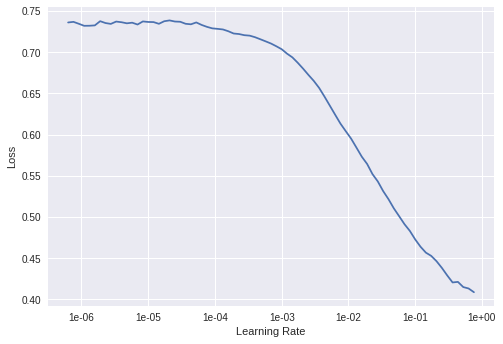

In [21]:
# find best lr
learn.lr_find()

# find best lr
learn.recorder.plot()

In [22]:
learn.fit(10, 1e-1)


epoch,train_loss,valid_loss,accuracy
1,0.112653,0.010898,0.999000
2,0.151258,0.122586,0.963500
3,0.239442,0.006953,1.000000
4,0.114339,0.222713,0.917500
5,0.100520,0.004154,1.000000
6,0.107814,0.100504,0.986000
7,0.104141,0.386878,0.802000
8,0.105179,0.025666,0.999500
9,0.103425,0.135911,0.961000
10,0.115187,0.044808,0.994000


In [0]:
learn.validate()

[0.10538929, tensor(0.9820)]

## Inference

In [0]:
row = df_train.iloc[0]
# print(df_train.dtypes)
# print(row)
type(row)

pandas.core.series.Series

In [0]:
learn.get_preds()

[tensor([[0.0143, 0.9857],
         [0.0122, 0.9878],
         [0.0712, 0.9288],
         ...,
         [0.0365, 0.9635],
         [0.1147, 0.8853],
         [0.1013, 0.8987]]), tensor([1, 1, 1,  ..., 1, 1, 1])]

# Predicting the result according to Odds

In [23]:
def odds_pred_result(odd_h,odd_d,odd_a):
    '''
    Predict game final result according to the odds for (home win, draw, and )
    Predict result of a match based on the highest odds for each result for a particular match
    '''
    if odd_h<odd_d and odd_h<odd_a:
        return("Home Win")
    elif odd_d<odd_h and odd_d<odd_a:
        return("Draw")
    elif odd_a<odd_d and odd_a<odd_h:
        return("Away Win")
    


# The next function would return the actual result of the match.
def actual_result(fthg,ftag):
    if fthg>ftag:
        return("Home Win")
    elif fthg==ftag:
        return("Draw")
    elif fthg<ftag:
        return("Away Win")
    
def actual_result_encode(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)
      
# We now compare the chances of us predicting the result of the game correctly just by looking at the odds.
def check_pred(data):
    correct=0
    wrong=0
    for i in range(1,data.shape[0]+1):
        odd_h=data[i-1:i]["odd_h"].item()
        odd_d=data[i-1:i]["odd_d"].item()
        odd_a=data[i-1:i]["odd_a"].item()
        fthg=data[i-1:i]["fthg"].item()
        ftag=data[i-1:i]["ftag"].item()
        oddsresult=odds_pred_result(odd_h,odd_d,odd_a)
        actresult=actual_result(fthg,ftag)
        if oddsresult==actresult:
            correct+=1
        else:
            wrong+=1
    return(str("%.2f"%(correct/(correct+wrong)))+str("% correct"))

with open('/content/gdrive/My Drive/ginf.csv', 'r') as f:
  df_game_info = pd.read_csv(f)
  
with open('/content/gdrive/My Drive/events.csv', 'r') as f:
  df_events = pd.read_csv(f)
  
  
print('Initial guess: ', check_pred(df_game_info))


'0.53% correct'

In [56]:
# x_odds = df_game_info.iloc[:,9:14]

     
df_odds_all = df_game_info.join(df_events, lsuffix='_odds', rsuffix='_events')# , how = 'inner')#, left_on = 'id_odsp', right_on = 'id_odsp')

df_odds_all = select_feats(df_odds_all, ['odd_h', 'odd_d', 'odd_a', 'event_team', 'opponent', 'league', 'side', 'fthg', 'ftag'])


# manually convert the dictionary.txt to python dicts
sides = {1:'Home', 2:'Away'}
leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
              'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

    
# Mapping the dicts into the events dataframe
df_odds_all['side'] = df_odds_all['side'].map(sides)
df_odds_all.league = df_odds_all.league.map(leagues)
    
    
# df_odds_all.info()

result=[]
for i in range(1, df_odds_all.shape[0]+1):
    result.append(actual_result_encode(df_odds_all[i-1:i]["fthg"].item(),
                                       df_odds_all[i-1:i]["ftag"].item()))
    
df_odds_all['result'] = pd.DataFrame(result)

df_odds_all["diff_h_d"] = abs(df_odds_all["odd_h"] - df_odds_all["odd_d"])
df_odds_all["diff_d_a"] = abs(df_odds_all["odd_d"] - df_odds_all["odd_a"])
df_odds_all["diff_h_a"] = abs(df_odds_all["odd_h"] - df_odds_all["odd_a"])

df_odds_all = df_odds_all.drop(["fthg","ftag"],axis=1)

df_odds_all.tail()

,odd_h,odd_d,odd_a,event_team,opponent,league,side,result,diff_h_d,diff_d_a,diff_h_a
10107,1.97,4.35,8.0,Lorient,Sochaux,Serie A,Away,2,2.38,3.65,6.03
10108,1.19,8.50,20.0,Sochaux,Lorient,Premier League,Home,1,7.31,11.50,18.81
10109,1.32,6.24,11.5,Lorient,Sochaux,League One,Away,1,4.92,5.26,10.18
10110,1.74,4.07,5.9,Sochaux,Lorient,La Liga,Home,2,2.33,1.83,4.16
10111,1.79,3.96,5.4,Lorient,Sochaux,Serie A,Away,1,2.17,1.44,3.61


In [59]:
x_odds_train, x_odds_test, y_odds_train, y_odds_test = train_test_split(df_odds_all.drop(['result'], axis=1), df_odds_all.result, test_size=0.2,random_state=0)


df_odds_train = x_odds_train.copy()
df_odds_train['result'] = y_odds_train
df_odds_train.result = df_odds_train.result.astype('category')

df_odds_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8089 entries, 8556 to 2732
Data columns (total 11 columns):
odd_h         8089 non-null float64
odd_d         8089 non-null float64
odd_a         8089 non-null float64
event_team    8089 non-null object
opponent      8089 non-null object
league        8089 non-null object
side          8089 non-null object
diff_h_d      8089 non-null float64
diff_d_a      8089 non-null float64
diff_h_a      8089 non-null float64
result        8089 non-null category
dtypes: category(1), float64(6), object(4)
memory usage: 703.1+ KB


In [62]:
valid_idx_odds = range(len(df_odds_train)-1000, len(df_odds_train))


# Final chosen/engineered features

feats_odds_cat = ['event_team', 'opponent', 'league', 'side']
d_cat = dict.fromkeys(feats_odds_cat, 'category')
df_odds_train = df_odds_train.astype(d_cat)
df_odds_train.info()

feats_odds_num =['odd_h', 'odd_d', 'odd_a', 'diff_h_d', 'diff_d_a', 'diff_h_a']

target_var_odds = 'result'

procs = [FillMissing, Categorify, Normalize]

test_odds = TabularList.from_df(df_odds_train.iloc[valid_idx_odds].copy(), cat_names = feats_odds_cat, cont_names= feats_odds_num)

data_odds = (TabularList.from_df(df_odds_train, cat_names = feats_odds_cat, cont_names= feats_odds_num)
                   .split_by_idx(valid_idx_odds)
                   .label_from_df(cols=target_var_odds)
                   .add_test(test_odds)        
                   .databunch())



# data = TabularDataBunch.from_df(path, df_train, target_var, valid_idx=valid_idx, cat_names=feats_cat)
print(data_odds.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8089 entries, 8556 to 2732
Data columns (total 11 columns):
odd_h         8089 non-null float64
odd_d         8089 non-null float64
odd_a         8089 non-null float64
event_team    8089 non-null category
opponent      8089 non-null category
league        8089 non-null category
side          8089 non-null category
diff_h_d      8089 non-null float64
diff_d_a      8089 non-null float64
diff_h_a      8089 non-null float64
result        8089 non-null category
dtypes: category(5), float64(6)
memory usage: 488.2 KB
['odd_h', 'odd_d', 'odd_a', 'diff_h_d', 'diff_d_a', 'diff_h_a']


In [64]:
learn = tabular_learner(data_odds, layers=[200, 200, 100], metrics=accuracy)
# find best lr
learn.lr_find()

# find best lr
learn.recorder.plot()

# Train the network
learn.fit(100, 1e-1)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy
1,1.033755,0.986478,0.529000
2,1.015018,9.891528,0.514000
3,1.020972,11.066001,0.445000
4,1.015994,9.405920,0.518000
5,1.005765,0.988190,0.516000
6,1.001960,24.589720,0.476000
7,1.010902,0.989184,0.503000
8,1.010024,3.600037,0.492000
9,1.006931,8.796710,0.518000
10,1.015065,1.022232,0.505000
